# Back-testing

> Modelo optimizado, evaluado en un semillerio

> Modelo semillerio de Denicolay

In [1]:
# Librerias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#######
# rutas
# datasets
from config import dataset_file_fe6_6xxpqt
# optimizacion
from config import db_path
# modelos
from config import modelos_path
# predicciones
from config import pred_path

##########
# pipeline
from processing import ModelPipeline, plot_comparisons_on_kaggle_split
from processing import analyze_study
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import optuna
import warnings

# Ignorar advertencias de tipo UserWarning
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
warnings.filterwarnings('ignore', category=Warning, module='lightgbm')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

/home/santtedo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Variables de train y test

In [2]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_3_meses = [202105, 202106, 202107]

mes_train_ult_6_meses = [202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_9_meses = [202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_anio = [202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train = [202107]
mes_test = 202109

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

## Loading data

In [4]:
data = pd.read_parquet(dataset_file_fe6_6xxpqt) 

# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

mes_bt_train_all = [
                    # 201901, 201902, 201903, 201904, 201906, 201907, # no los agregó por rotura de variables creadas
                    201908, 201909, 201911, 201912, 202001, 202002, 
                    202003, 202008, 202009, 202010, 202011, 202012,
                    202101, 202102, 202103, 202104, 202105
                    ] # igualmente habra variables perturbadas en los meses que no son tenidos en cuenta

X_train = data[data['foto_mes'].isin(mes_bt_train_all)]
y_train = X_train['clase_ternaria']
X_train = X_train.drop(columns=['clase_ternaria'])

mes_futuro = 202107 # usado como test
X_test = data[data['foto_mes'] == mes_futuro]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

del data

Preprocesando data

In [5]:
# Imputacion de Xs
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
print("Columns with all NaN values:", cols_with_all_nan)
X_train = X_train.drop(columns=cols_with_all_nan)
X_test = X_test.drop(columns=cols_with_all_nan)

# Imputación de nulls
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

del X_train
del X_test

# Codificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

Columns with all NaN values: ['payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


Función de ganancia

In [6]:
def ganancia(y, y_hat, thr, 
             ganancia_acierto = ganancia_acierto, 
             costo_estimulo = costo_estimulo,
             target = 2, prop=1):

    # Calcular la ganancia para cada fila
    gains = np.where(y_hat >= thr, np.where(y == target, ganancia_acierto, -costo_estimulo), 0)

    # Sumar las ganancias
    estimated_gain = gains.sum()/prop

    return estimated_gain

## Modelos candidatos

Luego de una comparación de modelos candidatos en comp03_lastdacexx

Se decide optar como **modelo optimizado** el:

> **lgbm prepro6 fe6 y 12 opt (local opt)**

Mientras que, para calcular una predicción con semillerío:

> **semillero de Denicolay**

semillerio_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.2,
                  'extra_trees': False,
                  'random_state': semillas[s],
}

## Evaluación de semillerios 

Que incluya una nuevaa evaluación del punto de corte

Aparte del hecho en comp03_back-testing, que ya sugiere el umbral óptimo

Entrenamiento con óptimos parámetros

**Modelo optimizado** para comp03

Con las distintas semillas

Para datos xx, con lag2 y delta2

In [7]:
from lightgbm import LGBMClassifier

# Tomando al mejor modelo optimizado

prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = 3 # un mes de optimización

storage_name = "sqlite:///" + db_path + "optimization_tree.db"
# carga local
# storage_name = "sqlite:///optimizacion/optimization_tree.db"
study_name = f"exp_lgbm_comp03_local_v00"

study = optuna.load_study(study_name=study_name, storage=storage_name)

# Mejores parámetros
opt_params = study.best_trial.params
opt_params.update({'n_jobs': -1})

print("Running back-testing for LGBMClassifier Opt")
print(opt_params)

# para registrar las probabilidades
df_s_proba = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                        })

label_antimapping = {0:'CONTINUA', 1:'BAJA+1', 2:'BAJA+2'}
df_s_proba['clase_ternaria'] = df_s_proba['baja'].map(label_antimapping)

df_lgbm_semillerios = pd.DataFrame()

semillerio = []
l_max_gan = []
l_max_gan_thr = []
l_max_gan_esti = []

i = 0
r_sem = range(217163, 455783, 7*7*7*7*100) # 1 semillerio
sem_total = len(list(range(217163, 455783, 7*7*7*7*100)))
r_s = range(217163, 455783, 7*7*7*7*10) # 10 semillas
s_total = len(list(range(217163, 455783, 7*7*7*7*10)))

for sem in r_sem:
    print(f"\n\n# Semillerio: {sem}, {i+1} de {sem_total}")

    # para operar sobre el semillerio
    df_s = df_s_proba

    j = 0
    for s in r_s:
        # nueva instancia del modelos con semilla
        seed = s+(7+j)**i
        model = LGBMClassifier(**opt_params, random_state=seed)
        # entreno
        print(f"\nEntrenando modelo con semilla: {seed}, {j+1} de {s_total}")
        model.fit(X_train_imp, y_train)
        # predigo proba
        y_pred_proba = model.predict_proba(X_test_imp)
        # proba baja+2
        proba_baja2 = y_pred_proba[:,2]
        df_s[f'proba_s{seed}'] = proba_baja2
        j += 1

    # calculando proba mean
    proba_s_columns = df_s.filter(regex='^proba_s')
    proba_s_mean = proba_s_columns.mean(axis=1)

    df_s['proba_sem_mean'] = proba_s_mean  

    # dataframe con el test
    test_results = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                            'proba_sem_baja2' : df_s['proba_sem_mean'].values
                        })
    test_results['clase_ternaria'] = test_results['baja'].map(label_antimapping)

    # ganancias según threshold
    thrs = []
    ganancias = []
    estimulos = []
    for thr in np.linspace(0.01, 0.03, 1000):
        gain = ganancia(test_results.baja, test_results.proba_sem_baja2, thr)
        esti = np.where(test_results.proba_sem_baja2 >= thr, 1, 0).sum()
        thrs.append(thr)
        ganancias.append(gain)
        estimulos.append(esti)
            
    df_lgbm_semillerios[f'threshold'] = thrs # será siempre igual
    df_lgbm_semillerios[f'ganancias_{sem}'] = ganancias # 
    df_lgbm_semillerios[f'estimulos_{sem}'] = estimulos # 

    # maxima ganancia y condiciones
    max_gan_idx = df_lgbm_semillerios[f'ganancias_{sem}'].idxmax()
    max_gan_thr = df_lgbm_semillerios['threshold'][max_gan_idx]
    max_gan = df_lgbm_semillerios[f'ganancias_{sem}'][max_gan_idx]
    max_estimulos = df_lgbm_semillerios[f'estimulos_{sem}'][max_gan_idx]
        
    print(f"sem: {sem}, ganancia max: {max_gan}, thr: {max_gan_thr}, estimulos: {max_estimulos}")
    
    # registro condiciones de maxima para summary
    semillerio.append(sem)
    l_max_gan_thr.append(max_gan_thr)
    l_max_gan.append(max_gan)
    l_max_gan_esti.append(max_estimulos)

    i += 1

df_lgbm_semillerios_summary = pd.DataFrame({
                            'semillerio': semillerio,
                            'thr_max_gan': l_max_gan_thr,
                            'max_gan': l_max_gan,
                            'est_max_gan': l_max_gan_esti,
                        })

Running back-testing for LGBMClassifier Opt
{'n_estimators': 586, 'num_leaves': 72, 'learning_rate': 0.03225820947502308, 'min_data_in_leaf': 182, 'feature_fraction': 0.5612204369575097, 'n_jobs': -1}


# Semillerio: 217163, 1 de 1

Entrenando modelo con semilla: 217164, 1 de 10
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] feature_fraction is set=0.5612204369575097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5612204369575097
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] feature_fraction is set=0.5612204369575097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5612204369575097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 11.888394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[

Análisis del semillerio

In [8]:
df_lgbm_semillerios.head()

,threshold,ganancias_217163,estimulos_217163
0,0.01000,158683000.0,17771
1,0.01002,158564000.0,17748
2,0.01004,158718000.0,17726
3,0.01006,158914000.0,17698
4,0.01008,158816000.0,17672


In [9]:
df_lgbm_semillerios_summary.head()

,semillerio,thr_max_gan,max_gan,est_max_gan
0,217163,0.018228,166894000.0,11638


In [10]:
df_lgbm_semillerios.to_csv(pred_path+'df_lgbm_semilleriosxx.csv')

In [11]:
df_lgbm_semillerios_summary.to_csv(pred_path+'df_lgbm_semillerios_summaryxx.csv')

Visualización

In [12]:
def plot_ganancias_estimulos(df_sem):
    fig, ax1 = plt.subplots()

    # Iterar sobre cada columna de ganancias y estimulos
    for sem in df_sem.columns:
        if sem.startswith('ganancias_'):
            ganancias = df_sem[sem]
            threshold = df_sem['threshold']
            
            # Plot A: Threshold vs Ganancias in gray
            ax1.plot(threshold, ganancias, color='gray')

    # Calcular y graficar las ganancias y estímulos promedio
    ganancias_avg = df_sem[[col for col in df_sem.columns if col.startswith('ganancias_')]].mean(axis=1)
    estimulos_avg = df_sem[[col for col in df_sem.columns if col.startswith('estimulos_')]].mean(axis=1)
    
    # Plot average in black
    ax1.plot(threshold, ganancias_avg, label='Ganancias Promedio', color='black', linestyle='--')

    # Highlight maximum gain
    max_gain_idx = ganancias_avg.idxmax()
    max_gain_threshold = threshold[max_gain_idx]
    max_gain = max(ganancias_avg)
    max_estimulos = estimulos_avg[max_gain_idx]

    ax1.scatter(max_gain_threshold, max_gain, color='red', zorder=5)
    ax1.annotate(f"Max Gain: {max_gain}\nThresh: {max_gain_threshold:.3f}\nEstim: {max_estimulos}", 
                (max_gain_threshold, max_gain), textcoords="offset points", xytext=(0,-20), ha='center')

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Ganancias')
    ax1.legend()
    plt.title('Ganancias vs Threshold para cada Semillerio')
    plt.show()

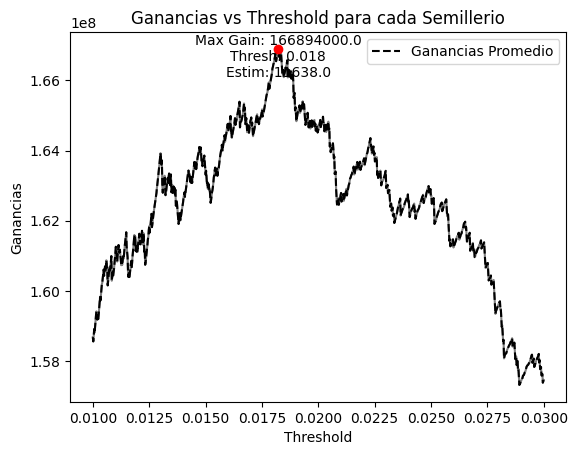

In [13]:
plot_ganancias_estimulos(df_lgbm_semillerios)

**Modelo semillerio**

Con las distintas semillas, según Denicolay

In [14]:
len(list(range(217163, 455783, 7*7*7*6)))

116

In [ ]:
from lightgbm import LGBMClassifier

semillero_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.25,
                  'extra_trees': False,
}

semillero_params.update({'n_jobs': -1})

print("Running back-testing for Semillerio Denicolay")
print(semillero_params)

# para registrar las probabilidades
df_s_proba = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                        })

label_antimapping = {0:'CONTINUA', 1:'BAJA+1', 2:'BAJA+2'}
df_s_proba['clase_ternaria'] = df_s_proba['baja'].map(label_antimapping)

df_semillerios = pd.DataFrame()

semillerio = []
l_max_gan = []
l_max_gan_thr = []
l_max_gan_esti = []

i = 0
r_sem = range(217163, 455783, 7*7*7*7*100) # 1 semillerio
sem_total = len(list(range(217163, 455783, 7*7*7*7*100)))
r_s = range(217163, 455783, 7*7*7*6) # 116 semillas
s_total = len(list(range(217163, 455783, 7*7*7*6)))

for sem in r_sem:
    print(f"\n\n# Semillerio: {sem}, {i+1} de {sem_total}")

    # para operar sobre el semillerio
    df_s = df_s_proba

    j = 0
    for s in r_s:
    #for s in range(0,2):
        # nueva instancia del modelos con semilla
        seed = s+(7+j)**i
        model = LGBMClassifier(**semillero_params, random_state=seed)
        # entreno
        print(f"\nEntrenando modelo con semilla: {seed}, {j+1} de {s_total}")
        model.fit(X_train_imp, y_train)
        # predigo proba
        y_pred_proba = model.predict_proba(X_test_imp)
        # proba baja+2
        proba_baja2 = y_pred_proba[:,2]
        df_s[f'proba_s{seed}'] = proba_baja2
        j += 1
    
    # calculando proba mean
    proba_s_columns = df_s.filter(regex='^proba_s')
    proba_s_mean = proba_s_columns.mean(axis=1)

    df_s['proba_sem_mean'] = proba_s_mean  

    # dataframe con el test
    test_results = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                            'proba_sem_baja2' : df_s['proba_sem_mean'].values
                        })
    test_results['clase_ternaria'] = test_results['baja'].map(label_antimapping)

    # ganancias según threshold
    thrs = []
    ganancias = []
    estimulos = []
    for thr in np.linspace(0.01, 0.03, 1000):
        gain = ganancia(test_results.baja, test_results.proba_sem_baja2, thr)
        esti = np.where(test_results.proba_sem_baja2 >= thr, 1, 0).sum()
        thrs.append(thr)
        ganancias.append(gain)
        estimulos.append(esti)
            
    df_semillerios[f'threshold'] = thrs # será siempre igual
    df_semillerios[f'ganancias_{sem}'] = ganancias # 
    df_semillerios[f'estimulos_{sem}'] = estimulos # 

    # maxima ganancia y condiciones
    max_gan_idx = df_semillerios[f'ganancias_{sem}'].idxmax()
    max_gan_thr = df_semillerios['threshold'][max_gan_idx]
    max_gan = df_semillerios[f'ganancias_{sem}'][max_gan_idx]
    max_estimulos = df_semillerios[f'estimulos_{sem}'][max_gan_idx]
        
    print(f"sem: {sem}, ganancia max: {max_gan}, thr: {max_gan_thr}, estimulos: {max_estimulos}")
    
    # registro condiciones de maxima para summary
    semillerio.append(sem)
    l_max_gan_thr.append(max_gan_thr)
    l_max_gan.append(max_gan)
    l_max_gan_esti.append(max_estimulos)

    i += 1

df_semillerios_summary = pd.DataFrame({
                            'semillerio': semillerio,
                            'thr_max_gan': l_max_gan_thr,
                            'max_gan': l_max_gan,
                            'est_max_gan': l_max_gan_esti,
                        })

Running back-testing for Semillerio Denicolay
{'n_estimators': 23, 'num_leaves': 32, 'learning_rate': 0.34, 'min_data_in_leaf': 711, 'feature_fraction': 0.25, 'extra_trees': False, 'n_jobs': -1}


# Semillerio: 217163, 1 de 1

Entrenando modelo con semilla: 217164, 1 de 116
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.971607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

In [ ]:
df_semillerios.head()

In [ ]:
df_semillerios_summary.head()

In [ ]:
df_semillerios.to_csv(pred_path+'df_profe_semillerios_03xx.csv')

In [ ]:
df_semillerios_summary.to_csv(pred_path+'df_profe_semillerios_summary_03xx.csv')

In [ ]:
plot_ganancias_estimulos(df_semillerios)

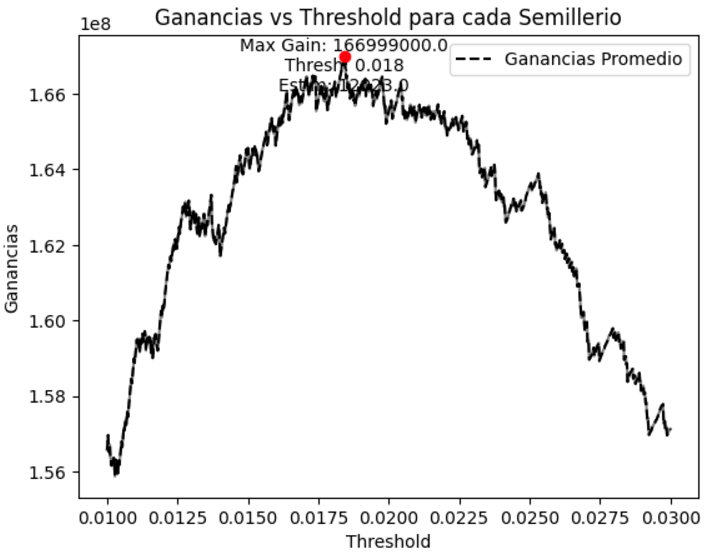

### Comparación de semillerios

Con métodos visuales

In [ ]:
def plot_ganancias_todas_superpuestas(df_sem1, df_sem2):
    fig, ax1 = plt.subplots()

    # Colores y nombres para cada modelo
    colores = ['blue', 'green']
    modelos = [df_sem1, df_sem2]
    nombres_modelos = ['lgbm sem', 'denicolay sem']

    for i, df_sem in enumerate(modelos):
        color = colores[i]
        nombre_modelo = nombres_modelos[i]
        
        # Obtener el threshold
        threshold = df_sem['threshold']
        
        # Graficar ganancias individuales
        for sem in df_sem.columns:
            if sem.startswith('ganancias_'):
                ganancias = df_sem[sem]
                ax1.plot(threshold, ganancias, color=color, alpha=0.1)
        
        # Calcular y graficar las ganancias promedio
        ganancias_cols = [col for col in df_sem.columns if col.startswith('ganancias_')]
        ganancias_avg = df_sem[ganancias_cols].mean(axis=1)
        ax1.plot(threshold, ganancias_avg, label=f'Ganancias Promedio {nombre_modelo}', color=color, linewidth=2)
        
        # Destacar la ganancia máxima
        max_gain_idx = ganancias_avg.idxmax()
        max_gain_threshold = threshold.iloc[max_gain_idx]
        max_gain = ganancias_avg.iloc[max_gain_idx]
        
        ax1.scatter(max_gain_threshold, max_gain, color=color, zorder=5)
        ax1.annotate(f"Max Gain {nombre_modelo}: {max_gain:.2f}\nThresh: {max_gain_threshold:.3f}", 
                    (max_gain_threshold, max_gain), textcoords="offset points", xytext=(0,-20*(i+1)), ha='center', color=color)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Ganancias')
    ax1.legend()
    plt.title('Comparación de Ganancias vs Threshold entre Modelos')
    plt.show()

In [ ]:
plot_ganancias_todas_superpuestas(df_lgbm_semillerios, df_semillerios)

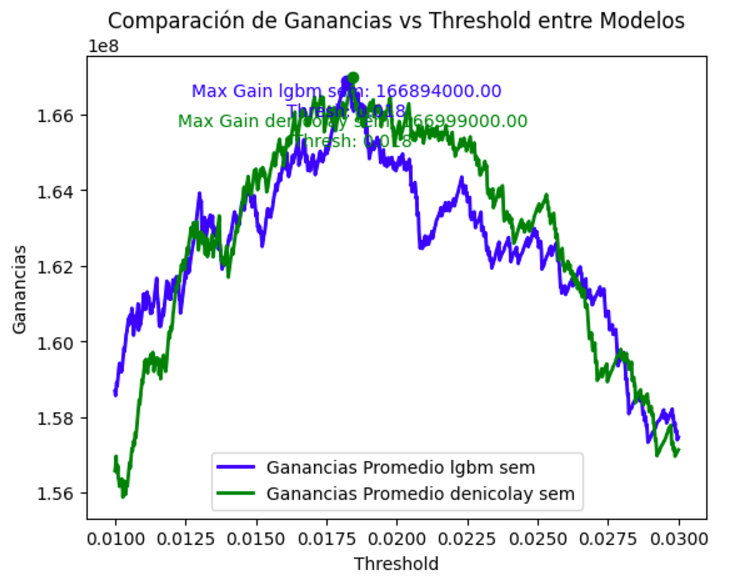

In [ ]:
def plot_ganancias_promedio_superpuestas(df_sem1, df_sem2):
    fig, ax1 = plt.subplots()

    # Colores y nombres para cada modelo
    colores = ['blue', 'green']
    modelos = [df_sem1, df_sem2]
    nombres_modelos = ['lgbm sem', 'denicolay sem']

    for i, df_sem in enumerate(modelos):
        color = colores[i]
        nombre_modelo = nombres_modelos[i]
        
        # Obtener el threshold
        threshold = df_sem['threshold']
        
        # Calcular las ganancias promedio
        ganancias_cols = [col for col in df_sem.columns if col.startswith('ganancias_')]
        ganancias_avg = df_sem[ganancias_cols].mean(axis=1)
        
        # Graficar las ganancias promedio
        ax1.plot(threshold, ganancias_avg, label=f'Ganancias Promedio {nombre_modelo}', color=color)
        
        # Destacar la ganancia máxima
        max_gain_idx = ganancias_avg.idxmax()
        max_gain_threshold = threshold.iloc[max_gain_idx]
        max_gain = ganancias_avg.iloc[max_gain_idx]
        
        ax1.scatter(max_gain_threshold, max_gain, color=color, zorder=5)
        ax1.annotate(f"Max Gain {nombre_modelo}: {max_gain:.2f}\nThresh: {max_gain_threshold:.3f}", 
                    (max_gain_threshold, max_gain), textcoords="offset points", xytext=(0,-20*(i+1)), ha='center', color=color)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Ganancias Promedio')
    ax1.legend()
    plt.title('Comparación de Ganancias Promedio vs Threshold entre Modelos')
    plt.show()

In [ ]:
plot_ganancias_promedio_superpuestas(df_lgbm_semillerios, df_semillerios)

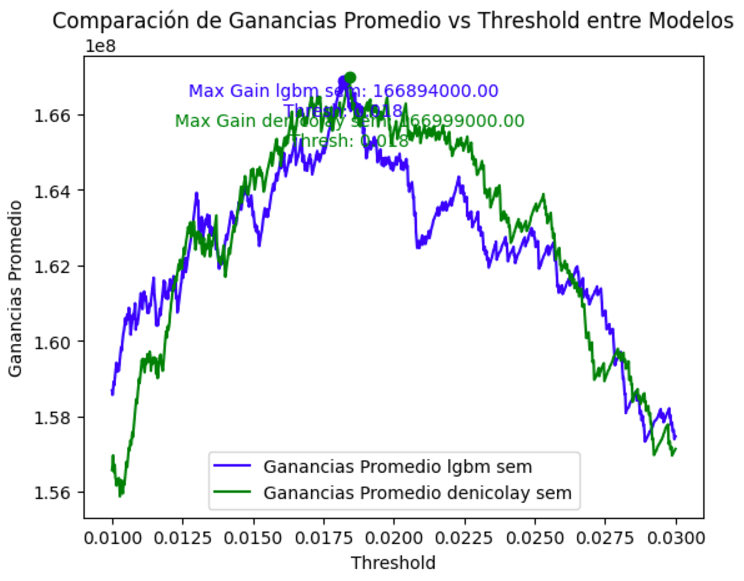

______